<a href="https://colab.research.google.com/github/yuncaich/TFG_Proyect/blob/main/TFG/Clasification_medMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install medmnist
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=33ace90ea0e189ebb0a3d72322eb8d935aac1f4e985f4183c90206527d5614be
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import Augmentor
import medmnist
from Augmentor import Operations as AugOper
from PIL import Image
from medmnist import INFO, Evaluator
from torch.utils.data import WeightedRandomSampler

<h1>Hiperparametros




In [4]:
data_flag = 'dermamnist'

NUM_EPOCHS = 10
BATCH_SIZE = 500
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = info['label']

DataClass = getattr(medmnist, info['python_class'])



<h1>Dataloader , Sampler y Augmentor

In [5]:
#normalize
# preprocessing
data_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
pil_dataset = DataClass(split='train', download=True)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [6]:
def sampler_weight(datasets):
  N = len(datasets)
  N0 = 0
  N1 = 0
  N2 = 0
  N3 = 0
  N4 = 0
  N5 = 0
  N6 = 0

  for i, j in datasets:
    for x in j:
      if x.item() == 0:
        N0 += 1
      if x.item() == 1:
        N1 += 1
      if x.item() == 2:
        N2 += 1
      if x.item() == 3:
        N3 += 1
      if x.item() == 4:
        N4 += 1
      if x.item() == 5:
        N5 += 1
      if x.item() == 6:
        N6 += 1  

  class_weights = [N/N0, N/N1, N/N2, N/N3, N/N4, N/N5, N/N6]
  sample_weights = [0] * len(train_dataset)

  for id , (data, targets) in enumerate(datasets):
    class_weight = class_weights[targets.item()]
    sample_weights[id] = class_weight

  sampler = WeightedRandomSampler(sample_weights , num_samples=N , replacement=True)
  return sampler


In [7]:

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False,sampler=sampler_weight(train_dataset))
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

<h1>Focal Loss

In [8]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2, size_average = True):
    super(FocalLoss, self).__init__()
    self.size_average = size_average
    self.alpha = alpha
    self.gamma = torch.Tensor([gamma])
    if isinstance(alpha, (float, int)):
      if self.alpha > 1:
        raise ValueError('Not supported value, alpha should be small than 1.0')
      else:
        self.alpha = torch.Tensor([alpha, 1.0 - alpha])
    if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
    self.alpha /= torch.sum(self.alpha)

  def forward(self, input, target):
    input= torch.softmax(input,dim=1)
    if input.dim() > 2:
      input = input.view(input.size(0), input.size(1), -1)
      if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
    target = target.view(-1, 1)
    logpt = torch.log(input + 1e-10)
    logpt = logpt.gather(1, target)
    logpt = logpt.view(-1, 1)
    pt = torch.exp(logpt)
    alpha = self.alpha.gather(0, target.view(-1))
 
    gamma = self.gamma
 
    if not self.gamma.device == input.device:
      gamma = torch.tensor(self.gamma, device=input.device)
 
    loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
    if self.size_average:
      loss = loss.mean()
    else:
      loss = loss.sum()
    return loss
    
    

<h1>Visualizar

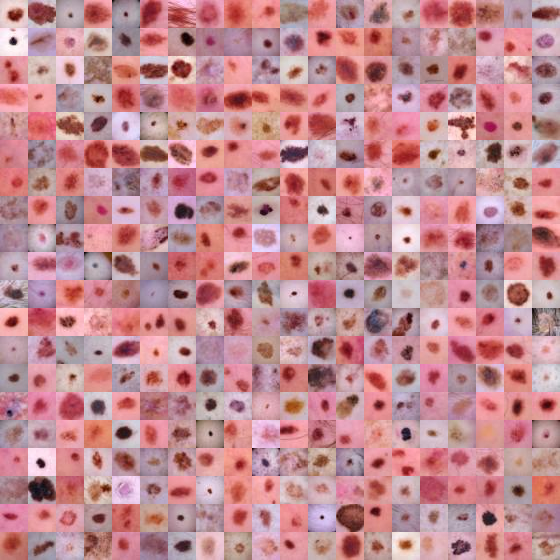

In [9]:
# visualization

#train_dataset.montage(length=40)

from matplotlib import pyplot
import numpy as np

train_dataset.montage()



<h1>Modelo

In [57]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, len(num_classes)))
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss([7/7,7/7,7/7,2/7,7/7,7/7,7/7] ,gamma=2)

    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

<h1>Entrenar

In [58]:
# train
from torchvision.transforms import ToTensor
for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
            
        if task == 'multi-label, binary-class':
                targets = targets.to(torch.int64)
                loss = criterion(outputs, targets)
        else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        #print( "Train epoch  : {} \t Loss : {:.6f}".format(epoch , loss.item()))

100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


In [26]:
#torch.save(model, "/content/drive/MyDrive/Clasificacion/focalLossAcc0.6.pth")

<h1>Test

In [31]:
#model = torch.load("/content/drive/MyDrive/Clasificacion/focalLossAcc0.6.pth")

In [54]:
from prettytable import PrettyTable
import matplotlib.pyplot as plt

class ConfusionMatrix(object):

  def __init__(self, num_classes: int, labels: list):
    self.matrix = np.zeros((num_classes,num_classes))
    self.num_classes = num_classes
    self.labels = labels

  def update(self, preds, labels):
    for p, t in zip(preds, labels):
      #p = p.astype(int)
      t = t.astype(int)
      self.matrix[t,p] += 1

  def summary(self):
    #calcular accuracy
    sum_TP = 0
    for i in range(self.num_classes):
      sum_TP += self.matrix[i,i]
      
    acc = sum_TP/np.sum(self.matrix)
    print("The model accuracy is" , acc)

     #Presicion, recal, specificity
    table = PrettyTable()
    table.field_names = ["", "Presicion", "Recall", "Specificity"]

    for i in range (self.num_classes):
      TP = self.matrix[i,i]
      FP = np.sum(self.matrix[i, :]) - TP
      FN = np.sum(self.matrix[:, i]) - TP
      TN = np.sum(self.matrix) - TP - FP - FN

      Presicion = round(TP / (TP + FP), 3)
      Recall = round(TP / (TP + FN), 3)
      Specificity = round(TN / (TN + FP), 3)

      table.add_row([self.labels[i],Presicion,Recall,Specificity])
      
    print(table)
    
  def plot(self):
    matrix = self.matrix

    print(matrix) 

    plt.imshow(matrix , cmap=plt.cm.Blues)
      
    #X label 
    plt.xticks(range(self.num_classes) , self.labels, rotation=90 , size = "small")
      
    #y label

    plt.yticks(range(self.num_classes) , self.labels)

    #colorbar
    plt.colorbar()
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title("Confusion matrix")

    thresh = matrix.max() / 2
    for x in range (self.num_classes):  #columnas
      for y in range(self.num_classes):  #fila
        info = int(matrix[y,x])
        plt.text(x, y, info,                    #escribir valor
                    verticalalignment ='center',
                    horizontalalignment ='center',
                    color = "white" if info > thresh else "black")
          
    ##plt.tight_layout()
    plt.show()



==> Evaluating ...
test  auc: 0.720  acc:0.483
[[  8.  18.   6.   1.   1.  24.   8.]
 [ 11.  21.   7.   1.   0.  37.  26.]
 [ 27.  21.  27.   1.   8.  95.  41.]
 [  1.   3.   0.   0.   0.  17.   2.]
 [  5.  12.  11.   0.  27.  82.  86.]
 [ 12.  72.  38.   0.  34. 868. 317.]
 [  1.   2.   2.   0.   0.   7.  17.]]


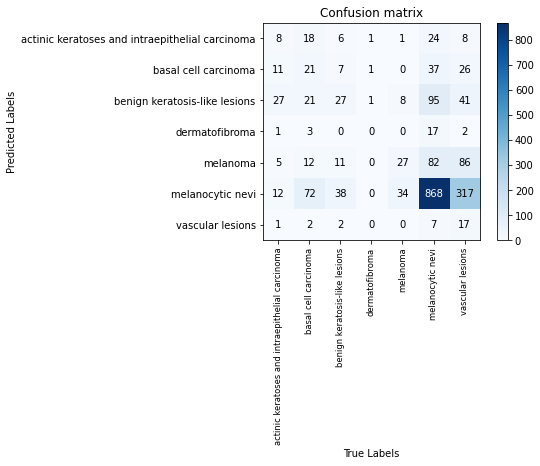

The model accuracy is 0.4827930174563591
+-------------------------------------------------+-----------+--------+-------------+
|                                                 | Presicion | Recall | Specificity |
+-------------------------------------------------+-----------+--------+-------------+
| actinic keratoses and intraepithelial carcinoma |   0.121   | 0.123  |     0.97    |
|               basal cell carcinoma              |   0.204   | 0.141  |    0.956    |
|          benign keratosis-like lesions          |   0.123   | 0.297  |    0.899    |
|                  dermatofibroma                 |    0.0    |  0.0   |    0.989    |
|                     melanoma                    |   0.121   | 0.386  |    0.899    |
|                 melanocytic nevi                |   0.647   | 0.768  |    0.459    |
|                 vascular lesions                |   0.586   | 0.034  |    0.992    |
+-------------------------------------------------+-----------+--------+-------------+


In [59]:
# evaluation
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    test_loss = 0.0
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    labels = [label for _,label in n_classes.items()]
    confusion = ConfusionMatrix(len(n_classes) , labels)

    with torch.no_grad():
        for inputs, targets in data_loader:

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            targets = targets.to(torch.int)
            confusion.update(torch.argmax(outputs,dim=1),targets.numpy())

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        #targets = targets.to(torch.int64)
        targets = targets.squeeze().long()
        test_loss += criterion(outputs, targets).item()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        #print(outputs[:7])
        #print(torch.argmax(outputs,dim=1))
        #print(test_loss)
        #matc=confusion_matrix(y_true, y_score[0])
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        
        confusion.plot()
        confusion.summary()
        
        
print('==> Evaluating ...')
#test('train')
test('test')

